### This notebook tries to replicate the binary classification problem that can be seen in approach three of the following paper: 

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4628806

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, classification_report
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Verificamos que la GPU está activada
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12211823545184626870
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2249719808
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6191490003883390029
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

### Load data

In [4]:
bitcoin_df = pd.read_csv("data/BTC_Hourly_for_LSTM.csv")

C:\Users\alrop\AppData\Local\Temp\ipykernel_23740\3393596681.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  bitcoin_df = pd.read_csv("data/BTC_Hourly_for_LSTM.csv")


In [5]:
bitcoin_df.head()

,DateTime,Open,High,Low,Close,Volume,l_price,l_ror,direction
0,2014-01-01 00:00:00,755.43,758.01,754.68,755.91,0,6.627922,Nan,Nan
1,2014-01-01 01:00:00,755.63,756.69,752.74,755.11,0,6.626863,-0.001058887,0
2,2014-01-01 02:00:00,755.19,756.03,752.41,753.15,0,6.624264,-0.002599023,0
3,2014-01-01 03:00:00,753.46,754.35,752.08,753.65,0,6.624928,0.000663658,1
4,2014-01-01 04:00:00,752.84,757.30,752.61,756.23,0,6.628346,0.003417493,1


In [6]:
bitcoin_df.dtypes

DateTime      object
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
l_price      float64
l_ror         object
direction     object
dtype: object

In [7]:
bitcoin_df.describe()

,Open,High,Low,Close,Volume,l_price
count,84937.000000,84937.000000,84937.000000,84937.000000,84937.0,84937.000000
mean,12902.211485,12957.385652,12844.552655,12902.689852,0.0,8.351907
std,15772.224164,15841.107515,15700.104646,15772.562376,0.0,1.777931
min,26.380000,178.370000,26.310000,174.120000,0.0,5.159745
25%,624.320000,626.050000,622.760000,623.940000,0.0,6.436054
50%,7077.310000,7116.240000,7041.560000,7078.670000,0.0,8.864841
75%,19776.300000,19845.030000,19701.330000,19779.620000,0.0,9.892407
max,68606.690000,68954.290000,68456.740000,68565.460000,0.0,11.135544


In [8]:
print(f"The dataset contains {len(bitcoin_df)} observations or rows and {len(bitcoin_df.columns)} variables or columns")

The dataset contains 84937 observations or rows and 9 variables or columns


In [9]:
bitcoin_df.rename(columns={'DateTime': 'datetime'}, inplace=True)
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'])

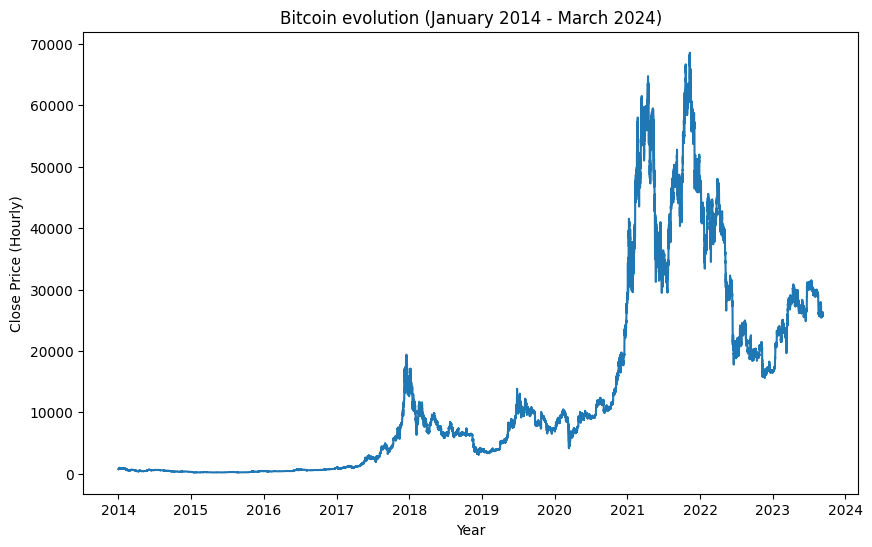

In [10]:
# Plot the time serie
plt.figure(figsize=(10,6))
sns.lineplot(data=bitcoin_df, x="datetime", y="Close")
plt.title("Bitcoin evolution (January 2014 - March 2024)")
plt.xlabel("Year")
plt.ylabel("Close Price (Hourly)")
plt.show()

## LSTM Model

In [11]:
# Prepare data frame for the classification variable
bitcoin_df['diff_close'] = bitcoin_df['Close'].diff()
bitcoin_df['Previous Close'] = bitcoin_df['Close'].shift(1)
bitcoin_df['Ticker'] = 'BTC'

In [12]:
bitcoin_df

,datetime,Open,High,Low,Close,Volume,l_price,l_ror,direction,diff_close,Previous Close,Ticker
0,2014-01-01 00:00:00,755.43,758.01,754.68,755.91,0,6.627922,Nan,Nan,NaN,NaN,BTC
1,2014-01-01 01:00:00,755.63,756.69,752.74,755.11,0,6.626863,-0.001058887,0,-0.80,755.91,BTC
2,2014-01-01 02:00:00,755.19,756.03,752.41,753.15,0,6.624264,-0.002599023,0,-1.96,755.11,BTC
3,2014-01-01 03:00:00,753.46,754.35,752.08,753.65,0,6.624928,0.000663658,1,0.50,753.15,BTC
4,2014-01-01 04:00:00,752.84,757.30,752.61,756.23,0,6.628346,0.003417493,1,2.58,753.65,BTC
...,...,...,...,...,...,...,...,...,...,...,...,...
84932,2023-09-09 20:00:00,25869.15,25878.00,25850.39,25861.58,0,10.160514,-0.000036,0,-0.93,25862.51,BTC
84933,2023-09-09 21:00:00,25868.33,25894.55,25852.15,25872.12,0,10.160921,0.000407,1,10.54,25861.58,BTC
84934,2023-09-09 22:00:00,25852.85,25900.21,25852.75,25870.40,0,10.160855,-0.000066,0,-1.72,25872.12,BTC
84935,2023-09-09 23:00:00,25890.20,25920.48,25884.87,25904.74,0,10.162181,0.001327,1,34.34,25870.40,BTC


In [13]:
bitcoin_df.dropna(subset = ['Previous Close'], inplace=True)
bitcoin_df['direction'] = pd.to_numeric(bitcoin_df['direction'])

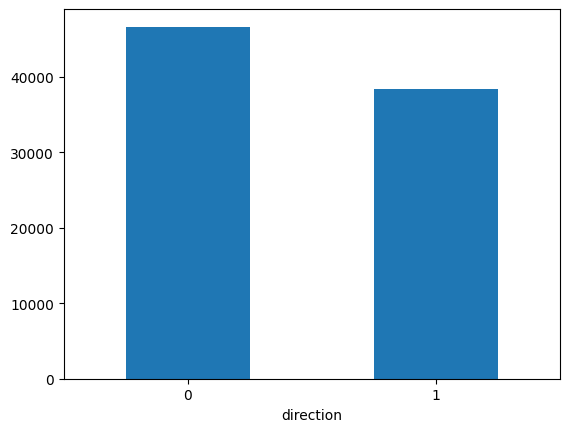

In [14]:
# Lets see the target variable in bars
bitcoin_df['direction'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

In [62]:
step = 720
all_predictions = []
all_labels = []
all_accuracies = []
T = 15

final_bitcoin_df = pd.DataFrame(columns=["datetime", "Ticker", 'Close', "scaled_close", "Previous Close", "direction"])

for i, n in enumerate(range(0, len(bitcoin_df) - step, step)):
    print(f"\nIteration {i + 1}")
    
    # Define train and test indexes for this iteration
    train_starts = n
    train_ends = n + step + T
    test_starts = train_ends
    test_ends = test_starts + step
    
    # Select train and test data using iloc
    train = bitcoin_final[["datetime", "Ticker", "Close", "direction", "Previous Close"]].iloc[train_starts:train_ends]
    test = bitcoin_final[["datetime", "Ticker", "Close", "direction", "Previous Close"]].iloc[test_starts:test_ends]

    # Normalize the train and test datasets
    scaler  = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train[['Close']])
    train['scaled_close'] = scaler.transform(train[['Close']])
    test['scaled_close'] = scaler.transform(test[['Close']])
    
    # Add last 15 data for train in test as they will be used to predict the first data in test
    test = pd.concat([train.iloc[-T:], test])
    
    # LSTM model
    # Create sequences of length 15 for the training set
    x_train, y_train = [], []
    for i in range(train.shape[0] - T):
        x_train.append(train['scaled_close'].iloc[i:i+T].values)
        y_train.append(train['direction'].iloc[i + T])

    x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1,1)
    # Reshape input data to fit LSTM requirements
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Repeat the same process for the test set
    x_test, y_test = [], []
    for i in range(test.shape[0] - T):
        x_test.append(test['scaled_close'].iloc[i:i+T].values)
        y_test.append(test['direction'].iloc[i + T])

    x_test, y_test = np.array(x_test), np.array(y_test).reshape(-1,1) 
    # Reshape input data to fit LSTM requirements
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # Define the model architecture
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
    model.add(Dropout(0.2, input_shape=(T, 1)))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    lr = 0.01
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])

    # Train the model
    batch_size = 32
    epochs = 50
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
    
    # Concat the data to the final data frame
    final_bitcoin_df = pd.concat([final_bitcoin_df, test[T:]])

    # Make the predictions (Probability of membership)
    y_pred = model.predict(x_test)
    all_predictions.extend(y_pred)
    all_labels.extend(y_test)
    
    test_accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
    all_accuracies.append(test_accuracy)



Iteration 1
Epoch 1/50
23/23 [==============================] - 3s 18ms/step - loss: 0.6655 - accuracy: 0.6264
Epoch 2/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6586 - accuracy: 0.6264
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6602 - accuracy: 0.6264
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6609 - accuracy: 0.6264
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6641 - accuracy: 0.6278
Epoch 6/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6604 - accuracy: 0.6264
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6566 - accuracy: 0.6264
Epoch 8/50
23/23 [==============================] - 0s 11ms/step - loss: 0.6565 - accuracy: 0.6264
Epoch 9/50
23/23 [==============================] - 0s 12ms/step - loss: 0.6589 - accuracy: 0.6264
Epoch 10/50
23/23 [==============================] - 0s 11ms/step - loss: 0.6578 - accuracy: 0.626

23/23 [==============================] - 0s 7ms/step - loss: 0.6588 - accuracy: 0.6361
Epoch 14/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6546 - accuracy: 0.6361
Epoch 15/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6575 - accuracy: 0.6361
Epoch 16/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6584 - accuracy: 0.6361
Epoch 17/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6571 - accuracy: 0.6361
Epoch 18/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6572 - accuracy: 0.6361
Epoch 19/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6567 - accuracy: 0.6361
Epoch 20/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6554 - accuracy: 0.6361
Epoch 21/50
23/23 [==============================] - 0s 11ms/step - loss: 0.6559 - accuracy: 0.6361
Epoch 22/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6562 - accuracy: 0.6361
Epoch 23/50
23/23 [=

23/23 [==============================] - 0s 9ms/step - loss: 0.6509 - accuracy: 0.6458
Epoch 46/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6504 - accuracy: 0.6458
Epoch 47/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6496 - accuracy: 0.6458
Epoch 48/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6516 - accuracy: 0.6458
Epoch 49/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6506 - accuracy: 0.6458
Epoch 50/50
23/23 [==============================] - 0s 3ms/step

Iteration 6
Epoch 1/50
23/23 [==============================] - 2s 14ms/step - loss: 0.6777 - accuracy: 0.6097
Epoch 2/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6719 - accuracy: 0.6111
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6704 - accuracy: 0.6111
Epoch 4/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6687 - accuracy: 0.6111
Epoch 5/50
23/23 [==========================

23/23 [==============================] - 0s 8ms/step - loss: 0.6559 - accuracy: 0.6444
Epoch 8/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6534 - accuracy: 0.6444
Epoch 9/50
23/23 [==============================] - 0s 7ms/step - loss: 0.6544 - accuracy: 0.6444
Epoch 10/50
23/23 [==============================] - 0s 7ms/step - loss: 0.6514 - accuracy: 0.6444
Epoch 11/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6511 - accuracy: 0.6444
Epoch 12/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6523 - accuracy: 0.6444
Epoch 13/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6503 - accuracy: 0.6444
Epoch 14/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6533 - accuracy: 0.6444
Epoch 15/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6517 - accuracy: 0.6444
Epoch 16/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6539 - accuracy: 0.6444
Epoch 17/50
23/23 [===

23/23 [==============================] - 0s 8ms/step - loss: 0.6499 - accuracy: 0.6292
Epoch 40/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6455 - accuracy: 0.6389
Epoch 41/50
23/23 [==============================] - 0s 7ms/step - loss: 0.6551 - accuracy: 0.6278
Epoch 42/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6557 - accuracy: 0.6347
Epoch 43/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6531 - accuracy: 0.6375
Epoch 44/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6522 - accuracy: 0.6236
Epoch 45/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6534 - accuracy: 0.6181
Epoch 46/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6527 - accuracy: 0.6333
Epoch 47/50
23/23 [==============================] - 0s 11ms/step - loss: 0.6497 - accuracy: 0.6347
Epoch 48/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6524 - accuracy: 0.6347
Epoch 49/50
23/23 

23/23 [==============================] - 2s 13ms/step - loss: 0.6855 - accuracy: 0.5931
Epoch 2/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6750 - accuracy: 0.6014
Epoch 3/50
23/23 [==============================] - 0s 11ms/step - loss: 0.6741 - accuracy: 0.6014
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6723 - accuracy: 0.6014
Epoch 5/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6739 - accuracy: 0.6014
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6736 - accuracy: 0.6014
Epoch 7/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6728 - accuracy: 0.6014
Epoch 8/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6722 - accuracy: 0.6014
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6741 - accuracy: 0.6014
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6738 - accuracy: 0.6014
Epoch 11/50
23/23 [========

23/23 [==============================] - 0s 9ms/step - loss: 0.6704 - accuracy: 0.6056
Epoch 34/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6693 - accuracy: 0.6056
Epoch 35/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6681 - accuracy: 0.6056
Epoch 36/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6704 - accuracy: 0.6056
Epoch 37/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6688 - accuracy: 0.6056
Epoch 38/50
23/23 [==============================] - 0s 9ms/step - loss: 0.6705 - accuracy: 0.6056
Epoch 39/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6696 - accuracy: 0.6056
Epoch 40/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6696 - accuracy: 0.6056
Epoch 41/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6697 - accuracy: 0.6056
Epoch 42/50
23/23 [==============================] - 0s 10ms/step - loss: 0.6689 - accuracy: 0.6056
Epoch 43/50
23/23 

Epoch 46/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6629 - accuracy: 0.6208
Epoch 47/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6654 - accuracy: 0.6056
Epoch 48/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6666 - accuracy: 0.6139
Epoch 49/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6648 - accuracy: 0.6111
Epoch 50/50
23/23 [==============================] - 1s 6ms/step

Iteration 19
Epoch 1/50
23/23 [==============================] - 2s 15ms/step - loss: 0.6797 - accuracy: 0.6042
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6687 - accuracy: 0.6139
Epoch 3/50
23/23 [==============================] - 0s 17ms/step - loss: 0.6679 - accuracy: 0.6139
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6672 - accuracy: 0.6139
Epoch 5/50
23/23 [==============================] - 0s 17ms/step - loss: 0.6697 - accuracy: 0.6139
Epoch 6/50
23/23 [============

23/23 [==============================] - 0s 13ms/step - loss: 0.6609 - accuracy: 0.6278
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6627 - accuracy: 0.6278
Epoch 8/50
23/23 [==============================] - 0s 15ms/step - loss: 0.6624 - accuracy: 0.6278
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6650 - accuracy: 0.6278
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6599 - accuracy: 0.6278
Epoch 11/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6646 - accuracy: 0.6278
Epoch 12/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6614 - accuracy: 0.6278
Epoch 13/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6599 - accuracy: 0.6278
Epoch 14/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6604 - accuracy: 0.6278
Epoch 15/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6609 - accuracy: 0.6278
Epoch 16/50
23/

23/23 [==============================] - 0s 13ms/step - loss: 0.6775 - accuracy: 0.5889
Epoch 18/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6779 - accuracy: 0.5889
Epoch 19/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6780 - accuracy: 0.5889
Epoch 20/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6786 - accuracy: 0.5889
Epoch 21/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6778 - accuracy: 0.5889
Epoch 22/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6778 - accuracy: 0.5889
Epoch 23/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6776 - accuracy: 0.5889
Epoch 24/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6784 - accuracy: 0.5889
Epoch 25/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6772 - accuracy: 0.5889
Epoch 26/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6775 - accuracy: 0.5889
Epoch 27/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6708 - accuracy: 0.5986
Epoch 29/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6699 - accuracy: 0.5986
Epoch 30/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6695 - accuracy: 0.5986
Epoch 31/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6709 - accuracy: 0.5986
Epoch 32/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6688 - accuracy: 0.5986
Epoch 33/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6723 - accuracy: 0.6000
Epoch 34/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6706 - accuracy: 0.5986
Epoch 35/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6678 - accuracy: 0.5986
Epoch 36/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6717 - accuracy: 0.5972
Epoch 37/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6674 - accuracy: 0.6014
Epoch 38/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6695 - accuracy: 0.6056
Epoch 40/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6693 - accuracy: 0.6069
Epoch 41/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6730 - accuracy: 0.6042
Epoch 42/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6693 - accuracy: 0.6069
Epoch 43/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6701 - accuracy: 0.6083
Epoch 44/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6694 - accuracy: 0.6069
Epoch 45/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6682 - accuracy: 0.6083
Epoch 46/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6702 - accuracy: 0.6069
Epoch 47/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6699 - accuracy: 0.6069
Epoch 48/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6697 - accuracy: 0.6056
Epoch 49/50


23/23 [==============================] - 1s 5ms/step

Iteration 35
Epoch 1/50
23/23 [==============================] - 2s 15ms/step - loss: 0.6719 - accuracy: 0.6236
Epoch 2/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6574 - accuracy: 0.6264
Epoch 3/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6600 - accuracy: 0.6264
Epoch 4/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6602 - accuracy: 0.6264
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6598 - accuracy: 0.6264
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6609 - accuracy: 0.6264
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6636 - accuracy: 0.6264
Epoch 8/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6609 - accuracy: 0.6264
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6592 - accuracy: 0.6264
Epoch 10/50
23/23 [=======================

Epoch 12/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6880 - accuracy: 0.5389
Epoch 13/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6923 - accuracy: 0.5389
Epoch 14/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6909 - accuracy: 0.5389
Epoch 15/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6898 - accuracy: 0.5389
Epoch 16/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6905 - accuracy: 0.5389
Epoch 17/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6912 - accuracy: 0.5389
Epoch 18/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6899 - accuracy: 0.5389
Epoch 19/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6900 - accuracy: 0.5389
Epoch 20/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6897 - accuracy: 0.5389
Epoch 21/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6900 - accuracy: 0.5389


23/23 [==============================] - 0s 13ms/step - loss: 0.6714 - accuracy: 0.6014
Epoch 24/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6724 - accuracy: 0.6014
Epoch 25/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6741 - accuracy: 0.6014
Epoch 26/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6723 - accuracy: 0.6014
Epoch 27/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6717 - accuracy: 0.6014
Epoch 28/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6715 - accuracy: 0.6014
Epoch 29/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6728 - accuracy: 0.6014
Epoch 30/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6715 - accuracy: 0.6014
Epoch 31/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6707 - accuracy: 0.6014
Epoch 32/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6735 - accuracy: 0.6014
Epoch 33/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6329 - accuracy: 0.6722
Epoch 35/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6340 - accuracy: 0.6722
Epoch 36/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6317 - accuracy: 0.6722
Epoch 37/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6348 - accuracy: 0.6722
Epoch 38/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6337 - accuracy: 0.6722
Epoch 39/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6333 - accuracy: 0.6722
Epoch 40/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6335 - accuracy: 0.6722
Epoch 41/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6340 - accuracy: 0.6722
Epoch 42/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6337 - accuracy: 0.6722
Epoch 43/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6337 - accuracy: 0.6722
Epoch 44/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6740 - accuracy: 0.6014
Epoch 46/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6719 - accuracy: 0.6014
Epoch 47/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6742 - accuracy: 0.6014
Epoch 48/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6725 - accuracy: 0.6014
Epoch 49/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6730 - accuracy: 0.6014
Epoch 50/50
23/23 [==============================] - 0s 4ms/step

Iteration 48
Epoch 1/50
23/23 [==============================] - 2s 16ms/step - loss: 0.6757 - accuracy: 0.6014
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6766 - accuracy: 0.6000
Epoch 3/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6744 - accuracy: 0.6014
Epoch 4/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6751 - accuracy: 0.6014
Epoch 5/50
23/23 [===================

23/23 [==============================] - 0s 14ms/step - loss: 0.6563 - accuracy: 0.6375
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6540 - accuracy: 0.6375
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6590 - accuracy: 0.6375
Epoch 8/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6603 - accuracy: 0.6375
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6589 - accuracy: 0.6375
Epoch 10/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6557 - accuracy: 0.6375
Epoch 11/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6553 - accuracy: 0.6375
Epoch 12/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6556 - accuracy: 0.6375
Epoch 13/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6558 - accuracy: 0.6375
Epoch 14/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6569 - accuracy: 0.6375
Epoch 15/50
23/2

23/23 [==============================] - 0s 14ms/step - loss: 0.6721 - accuracy: 0.5944
Epoch 18/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6709 - accuracy: 0.5944
Epoch 19/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6739 - accuracy: 0.5944
Epoch 20/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6717 - accuracy: 0.5944
Epoch 21/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6708 - accuracy: 0.5944
Epoch 22/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6709 - accuracy: 0.5944
Epoch 23/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6715 - accuracy: 0.5944
Epoch 24/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6710 - accuracy: 0.5944
Epoch 25/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6736 - accuracy: 0.5944
Epoch 26/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6711 - accuracy: 0.5944
Epoch 27/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.5139
Epoch 29/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6924 - accuracy: 0.5139
Epoch 30/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.4986
Epoch 31/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6941 - accuracy: 0.5167
Epoch 32/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6923 - accuracy: 0.4903
Epoch 33/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.5000
Epoch 34/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6927 - accuracy: 0.5069
Epoch 35/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.5167
Epoch 36/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6936 - accuracy: 0.4889
Epoch 37/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.5167
Epoch 38/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6917 - accuracy: 0.5236
Epoch 40/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.5236
Epoch 41/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6917 - accuracy: 0.5236
Epoch 42/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6921 - accuracy: 0.5236
Epoch 43/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6920 - accuracy: 0.5250
Epoch 44/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6922 - accuracy: 0.5236
Epoch 45/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6929 - accuracy: 0.5042
Epoch 46/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6920 - accuracy: 0.5236
Epoch 47/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.5236
Epoch 48/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6923 - accuracy: 0.5236
Epoch 49/50


23/23 [==============================] - 1s 4ms/step

Iteration 64
Epoch 1/50
23/23 [==============================] - 2s 16ms/step - loss: 0.6938 - accuracy: 0.5278
Epoch 2/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6922 - accuracy: 0.5222
Epoch 3/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6936 - accuracy: 0.5347
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6912 - accuracy: 0.5333
Epoch 5/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6914 - accuracy: 0.5347
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6913 - accuracy: 0.5319
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6916 - accuracy: 0.5417
Epoch 8/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6909 - accuracy: 0.5333
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6913 - accuracy: 0.5333
Epoch 10/50
23/23 [=======================

23/23 [==============================] - 0s 14ms/step - loss: 0.6912 - accuracy: 0.5361
Epoch 11/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6906 - accuracy: 0.5361
Epoch 12/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6919 - accuracy: 0.5403
Epoch 13/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6903 - accuracy: 0.5361
Epoch 14/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6902 - accuracy: 0.5361
Epoch 15/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6905 - accuracy: 0.5375
Epoch 16/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6907 - accuracy: 0.5361
Epoch 17/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6906 - accuracy: 0.5403
Epoch 18/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6915 - accuracy: 0.5361
Epoch 19/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6915 - accuracy: 0.5361
Epoch 20/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6895 - accuracy: 0.5500
Epoch 22/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6888 - accuracy: 0.5486
Epoch 23/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6891 - accuracy: 0.5486
Epoch 24/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6890 - accuracy: 0.5486
Epoch 25/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6886 - accuracy: 0.5486
Epoch 26/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6885 - accuracy: 0.5486
Epoch 27/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6888 - accuracy: 0.5486
Epoch 28/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6882 - accuracy: 0.5486
Epoch 29/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6890 - accuracy: 0.5486
Epoch 30/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6895 - accuracy: 0.5486
Epoch 31/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6929 - accuracy: 0.5042
Epoch 33/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6921 - accuracy: 0.5306
Epoch 34/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.5014
Epoch 35/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6911 - accuracy: 0.5319
Epoch 36/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6919 - accuracy: 0.5347
Epoch 37/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6923 - accuracy: 0.5194
Epoch 38/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.5111
Epoch 39/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.5194
Epoch 40/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6916 - accuracy: 0.5194
Epoch 41/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.4986
Epoch 42/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6927 - accuracy: 0.5014
Epoch 44/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6926 - accuracy: 0.4875
Epoch 45/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6927 - accuracy: 0.5000
Epoch 46/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.5111
Epoch 47/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6929 - accuracy: 0.4972
Epoch 48/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6927 - accuracy: 0.5208
Epoch 49/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.5069
Epoch 50/50
23/23 [==============================] - 0s 5ms/step

Iteration 77
Epoch 1/50
23/23 [==============================] - 2s 17ms/step - loss: 0.6946 - accuracy: 0.5194
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.5250
Epoch 3/50
23/23 [=================

23/23 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.4778
Epoch 4/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6934 - accuracy: 0.4972
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6962 - accuracy: 0.4667
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.5028
Epoch 7/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6934 - accuracy: 0.5028
Epoch 8/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6945 - accuracy: 0.4958
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.5056
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6942 - accuracy: 0.5014
Epoch 11/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 12/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6934 - accuracy: 0.4833
Epoch 13/50
23/23 

23/23 [==============================] - 0s 13ms/step - loss: 0.6882 - accuracy: 0.5486
Epoch 15/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6879 - accuracy: 0.5486
Epoch 16/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6900 - accuracy: 0.5486
Epoch 17/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6890 - accuracy: 0.5486
Epoch 18/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6889 - accuracy: 0.5486
Epoch 19/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6898 - accuracy: 0.5486
Epoch 20/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6892 - accuracy: 0.5486
Epoch 21/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6891 - accuracy: 0.5486
Epoch 22/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6883 - accuracy: 0.5486
Epoch 23/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6891 - accuracy: 0.5486
Epoch 24/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6834 - accuracy: 0.5514
Epoch 26/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6858 - accuracy: 0.5597
Epoch 27/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6852 - accuracy: 0.5361
Epoch 28/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6824 - accuracy: 0.5569
Epoch 29/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6862 - accuracy: 0.5569
Epoch 30/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6830 - accuracy: 0.5597
Epoch 31/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6831 - accuracy: 0.5472
Epoch 32/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6844 - accuracy: 0.5681
Epoch 33/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6845 - accuracy: 0.5444
Epoch 34/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6816 - accuracy: 0.5611
Epoch 35/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.4958
Epoch 37/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6939 - accuracy: 0.4833
Epoch 38/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.5069
Epoch 39/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6935 - accuracy: 0.4972
Epoch 40/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6933 - accuracy: 0.4958
Epoch 41/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6933 - accuracy: 0.4986
Epoch 42/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6932 - accuracy: 0.5250
Epoch 43/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6935 - accuracy: 0.5014
Epoch 44/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.4681
Epoch 45/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.5069
Epoch 46/50


23/23 [==============================] - 0s 14ms/step - loss: 0.6895 - accuracy: 0.5361
Epoch 48/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6899 - accuracy: 0.5250
Epoch 49/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6902 - accuracy: 0.5319
Epoch 50/50
23/23 [==============================] - 0s 5ms/step

Iteration 93
Epoch 1/50
23/23 [==============================] - 2s 16ms/step - loss: 0.6987 - accuracy: 0.5042
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6934 - accuracy: 0.5278
Epoch 3/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6926 - accuracy: 0.5181
Epoch 4/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6912 - accuracy: 0.5222
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6920 - accuracy: 0.5250
Epoch 6/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6928 - accuracy: 0.5181
Epoch 7/50
23/23 [=====================

23/23 [==============================] - 0s 15ms/step - loss: 0.6823 - accuracy: 0.5750
Epoch 8/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6808 - accuracy: 0.5750
Epoch 9/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6824 - accuracy: 0.5750
Epoch 10/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6818 - accuracy: 0.5750
Epoch 11/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6831 - accuracy: 0.5750
Epoch 12/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6819 - accuracy: 0.5750
Epoch 13/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6852 - accuracy: 0.5750
Epoch 14/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6811 - accuracy: 0.5750
Epoch 15/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6815 - accuracy: 0.5750
Epoch 16/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6829 - accuracy: 0.5750
Epoch 17/50
23

23/23 [==============================] - 0s 13ms/step - loss: 0.6923 - accuracy: 0.5389
Epoch 19/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6926 - accuracy: 0.5028
Epoch 20/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6958 - accuracy: 0.4653
Epoch 21/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6934 - accuracy: 0.5014
Epoch 22/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.5208
Epoch 23/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.5028
Epoch 24/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6941 - accuracy: 0.5000
Epoch 25/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.5069
Epoch 26/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.4861
Epoch 27/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6940 - accuracy: 0.4972
Epoch 28/50


23/23 [==============================] - 0s 13ms/step - loss: 0.6916 - accuracy: 0.5347
Epoch 30/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6911 - accuracy: 0.5347
Epoch 31/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6909 - accuracy: 0.5347
Epoch 32/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6913 - accuracy: 0.5347
Epoch 33/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6908 - accuracy: 0.5347
Epoch 34/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6909 - accuracy: 0.5347
Epoch 35/50
23/23 [==============================] - 0s 15ms/step - loss: 0.6913 - accuracy: 0.5347
Epoch 36/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6910 - accuracy: 0.5347
Epoch 37/50
23/23 [==============================] - 0s 13ms/step - loss: 0.6913 - accuracy: 0.5347
Epoch 38/50
23/23 [==============================] - 0s 14ms/step - loss: 0.6912 - accuracy: 0.5347
Epoch 39/50


In [63]:
# Accuracy average
print(f'Test accuracy: {np.round(np.average(all_accuracies), 2)}%')

Test accuracy: 0.56%


In [64]:
# Predictions as numpy arrays
all_predictions_array = np.array(all_predictions)
all_labels_array = np.array(all_labels)

# Threshold (more than 50% - buy; less than 50% - sell)
y_pred_binary = np.where(all_predictions_array > 0.5, 1, 0)

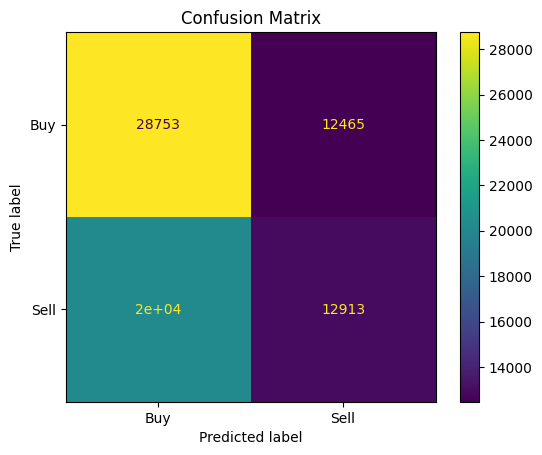

In [65]:
# Compute confusion matrix
conf_mat = confusion_matrix(all_labels_array, y_pred_binary)


# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Buy", "Sell"])

# Display confusion matrix
disp.plot()
plt.title("Confusion Matrix")

# Save the figure
plt.savefig("Confusion matrix.png", dpi=199)
plt.show()

In [69]:
# Add predictions to the final data frame
df_preds = pd.DataFrame(all_predictions, columns=['Probability of Class Membership'])
df_binary_preds = pd.DataFrame(y_pred_binary, columns=['Prediction'])
df_preds = pd.concat([df_preds.reset_index(drop=True), df_binary_preds], axis=1)
final_bitcoin_df = pd.concat([final_bitcoin_df.reset_index(drop=True), df_preds], axis=1)

In [70]:
final_bitcoin_df.rename(columns={'direction': 'Actual', 'scaled_close': 'Close Scaled'}, inplace=True)

In [71]:
final_bitcoin_df['Actual'] = np.where(final_bitcoin_df['Actual'] == 0, "Down", "Up")
final_bitcoin_df['Prediction'] = np.where(final_bitcoin_df['Prediction'] == 0, "Down", "Up")

In [72]:
final_bitcoin_df['Correct Prediction?'] = np.where(final_bitcoin_df['Actual'] == final_bitcoin_df['Prediction'], 1, 0)

In [73]:
final_bitcoin_df['Actual Change'] = round((final_bitcoin_df['Close']-final_bitcoin_df['Previous Close'])/
                                              final_bitcoin_df['Previous Close']*100, 2)
final_bitcoin_df['Actual Change'] = final_bitcoin_df['Actual Change'].map("{:,.2f}%".format)

In [74]:
final_bitcoin_df['Date'] = final_bitcoin_df['datetime'].dt.date
final_bitcoin_df['Time'] = final_bitcoin_df['datetime'].dt.time
final_bitcoin_df.drop(columns='datetime', inplace=True)

In [75]:
final_bitcoin_df = final_bitcoin_df[['Date', 'Time', 'Ticker', 'Prediction', 'Actual', 'Correct Prediction?',
                                     'Previous Close', 'Close', 'Close Scaled', 'Actual Change',
                                     'Probability of Class Membership']]

In [76]:
final_bitcoin_df

,Date,Time,Ticker,Prediction,Actual,Correct Prediction?,Previous Close,Close,Close Scaled,Actual Change,Probability of Class Membership
0,2014-01-31,16:00:00,BTC,Down,Down,1,849.24,849.05,0.961072,-0.02%,0.364335
1,2014-01-31,17:00:00,BTC,Down,Down,1,849.05,848.30,0.958931,-0.09%,0.309988
2,2014-01-31,18:00:00,BTC,Down,Down,1,848.30,848.09,0.958332,-0.02%,0.293308
3,2014-01-31,19:00:00,BTC,Down,Down,1,848.09,843.62,0.945575,-0.53%,0.282835
4,2014-01-31,20:00:00,BTC,Down,Up,0,843.62,844.87,0.949142,0.15%,0.278999
...,...,...,...,...,...,...,...,...,...,...,...
74355,2022-07-26,19:00:00,BTC,Up,Down,0,20950.53,20840.81,0.002510,-0.52%,0.749120
74356,2022-07-26,20:00:00,BTC,Up,Up,1,20840.81,20854.47,0.006622,0.07%,0.748007
74357,2022-07-26,21:00:00,BTC,Up,Up,1,20854.47,20904.11,0.021563,0.24%,0.745158
74358,2022-07-26,22:00:00,BTC,Up,Up,1,20904.11,20935.15,0.030906,0.15%,0.739261


In [77]:
class_rep = classification_report(all_labels_array, y_pred_binary, output_dict=True)
class_rep = pd.DataFrame(class_rep).transpose()

# Export the report to xlsx
class_rep.to_excel('data/Classification Report.xlsx', index=False)

In [78]:
class_rep

,precision,recall,f1-score,support
0,0.587012,0.697584,0.637539,41218.000000
1,0.508827,0.389626,0.441319,33142.000000
accuracy,0.560328,0.560328,0.560328,0.560328
macro avg,0.547919,0.543605,0.539429,74360.000000
weighted avg,0.552165,0.560328,0.550084,74360.000000


In [79]:
# Export the data to xlsx and the confussion matrix
final_bitcoin_df.to_excel('data/Bitcoin forecast.xlsx', index=False)

### Bibliography

https://www.linkedin.com/pulse/walk-forward-validation-yeshwanth-n